In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.inspection import permutation_importance
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, export_text

### Dataset

In this homework, we will use the Students Performance in 2024 JAMB dataset from [Kaggle](https://www.kaggle.com/datasets/idowuadamo/students-performance-in-2024-jamb).

Here's a wget-able [link](https://github.com/alexeygrigorev/datasets/raw/refs/heads/master/jamb_exam_results.csv):

```bash
wget https://github.com/alexeygrigorev/datasets/raw/refs/heads/master/jamb_exam_results.csv
```

The goal of this homework is to create a regression model for predicting the performance of students on a standardized test (column `'JAMB_Score'`).

In [3]:
!wget https://github.com/alexeygrigorev/datasets/raw/refs/heads/master/jamb_exam_results.csv

--2024-11-11 14:46:06--  https://github.com/alexeygrigorev/datasets/raw/refs/heads/master/jamb_exam_results.csv
Resolving github.com (github.com)... 20.26.156.215
Connecting to github.com (github.com)|20.26.156.215|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/alexeygrigorev/datasets/refs/heads/master/jamb_exam_results.csv [following]
--2024-11-11 14:46:07--  https://raw.githubusercontent.com/alexeygrigorev/datasets/refs/heads/master/jamb_exam_results.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 391501 (382K) [text/plain]
Saving to: ‘jamb_exam_results.csv.3’

jamb_exam_results.c 100%[===================>] 382.33K  --.-KB/s    in 0.007s  

2024-11-11 14:46:07 (51.3 MB/s) - ‘jamb_exam_re

### Preparing the dataset 

First, let's make the names lowercase:

```python
df.columns = df.columns.str.lower().str.replace(' ', '_')
```

Preparation:

* Remove the `student_id` column.
* Fill missing values with zeros.
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1.
* Use `DictVectorizer(sparse=True)` to turn the dataframes into matrices.

In [2]:
df = pd.read_csv('jamb_exam_results.csv')
df.head()

,JAMB_Score,Study_Hours_Per_Week,Attendance_Rate,Teacher_Quality,Distance_To_School,School_Type,School_Location,Extra_Tutorials,Access_To_Learning_Materials,Parent_Involvement,IT_Knowledge,Student_ID,Age,Gender,Socioeconomic_Status,Parent_Education_Level,Assignments_Completed
0,192,22,78,4,12.4,Public,Urban,Yes,Yes,High,Medium,1,17,Male,Low,Tertiary,2
1,207,14,88,4,2.7,Public,Rural,No,Yes,High,High,2,15,Male,High,NaN,1
2,182,29,87,2,9.6,Public,Rural,Yes,Yes,High,Medium,3,20,Female,High,Tertiary,2
3,210,29,99,2,2.6,Public,Urban,No,Yes,Medium,High,4,22,Female,Medium,Tertiary,1
4,199,12,98,3,8.8,Public,Urban,No,Yes,Medium,Medium,5,22,Female,Medium,Tertiary,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   JAMB_Score                    5000 non-null   int64  
 1   Study_Hours_Per_Week          5000 non-null   int64  
 2   Attendance_Rate               5000 non-null   int64  
 3   Teacher_Quality               5000 non-null   int64  
 4   Distance_To_School            5000 non-null   float64
 5   School_Type                   5000 non-null   object 
 6   School_Location               5000 non-null   object 
 7   Extra_Tutorials               5000 non-null   object 
 8   Access_To_Learning_Materials  5000 non-null   object 
 9   Parent_Involvement            5000 non-null   object 
 10  IT_Knowledge                  5000 non-null   object 
 11  Student_ID                    5000 non-null   int64  
 12  Age                           5000 non-null   int64  
 13  Gen

In [4]:
df.describe()

,JAMB_Score,Study_Hours_Per_Week,Attendance_Rate,Teacher_Quality,Distance_To_School,Student_ID,Age,Assignments_Completed
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,174.074600,19.521200,84.235200,2.521400,10.005460,2500.500000,18.445800,1.804600
std,47.616477,9.634569,9.485688,0.985564,4.820221,1443.520003,2.301504,0.992076
min,100.000000,0.000000,50.000000,1.000000,0.000000,1.000000,15.000000,1.000000
25%,135.000000,13.000000,78.000000,2.000000,6.600000,1250.750000,16.000000,1.000000
50%,170.000000,19.000000,84.000000,2.000000,10.000000,2500.500000,18.000000,1.000000
75%,209.000000,26.000000,91.000000,3.000000,13.400000,3750.250000,20.000000,2.000000
max,367.000000,40.000000,100.000000,5.000000,20.000000,5000.000000,22.000000,5.000000


In [5]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
df['parent_education_level'].value_counts(dropna=False)

parent_education_level
Secondary    1556
Primary      1335
Tertiary     1218
NaN           891
Name: count, dtype: int64

In [6]:
df = df.drop(columns='student_id').fillna(0)

In [7]:
X = df.drop(columns='jamb_score')
y = df['jamb_score']
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=1
)
dv = DictVectorizer(sparse=True)
X_train = dv.fit_transform(X_train.to_dict(orient='records'))
X_val = dv.transform(X_val.to_dict(orient='records'))

## Question 1

Let's train a decision tree regressor to predict the `jamb_score` variable. 

* Train a model with `max_depth=1`.


Which feature is used for splitting the data?

* `study_hours_per_week`
* `attendance_rate`
* `teacher_quality`
* `distance_to_school`

In [8]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [9]:
print(export_text(dt, feature_names=dv.feature_names_))

|--- study_hours_per_week <= 18.50
|   |--- value: [155.24]
|--- study_hours_per_week >  18.50
|   |--- value: [188.59]



## Question 2

Train a random forest regressor with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1` (optional - to make training faster)


What's the RMSE of this model on the validation data?

* 22.13
* 42.13
* 62.13
* 82.12

In [10]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)
y_val_pred = rf.predict(X_val)
root_mean_squared_error(y_val, y_val_pred)

np.float64(42.13724207871227)

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10.
* Set `random_state` to `1`.
* Evaluate the model on the validation dataset.


After which value of `n_estimators` does RMSE stop improving?
Consider 3 decimal places for calculating the answer.

- 10
- 25
- 80
- 200

In [11]:
rmses = []
for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)
    y_val_pred = rf.predict(X_val)
    rmses.append((n, root_mean_squared_error(y_val, y_val_pred)))
rmse_df = pd.DataFrame(rmses, columns=['n_estimators', 'rmse'])
rmse_df

,n_estimators,rmse
0,10,42.137242
1,20,41.461215
2,30,41.106171
3,40,40.917194
4,50,40.852279
5,60,40.784281
6,70,40.677098
7,80,40.539333
8,90,40.504346
9,100,40.516805


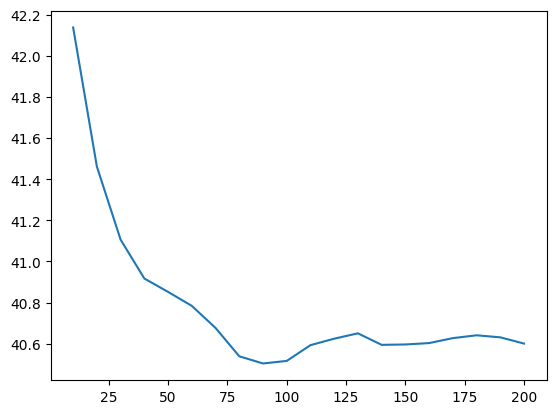

In [12]:
plt.plot(rmse_df['n_estimators'], rmse_df['rmse'])


## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values,
  * try different values of `n_estimators` from 10 till 200 (with step 10)
  * calculate the mean RMSE 
* Fix the random seed: `random_state=1`


What's the best `max_depth`, using the mean RMSE?

* 10
* 15
* 20
* 25

In [13]:
rmses = []
for d in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n, max_depth=d, random_state=1)
        rf.fit(X_train, y_train)
        y_val_pred = rf.predict(X_val)
        rmses.append((d, n, root_mean_squared_error(y_val, y_val_pred)))
rmse_df = pd.DataFrame(rmses, columns=['max_depth', 'n_estimators', 'rmse'])
rmse_df

,max_depth,n_estimators,rmse
0,10,10,41.258349
1,10,20,40.880528
2,10,30,40.624956
3,10,40,40.270069
4,10,50,40.317006
...,...,...,...
75,25,160,40.600208
76,25,170,40.624371
77,25,180,40.638564
78,25,190,40.628661


In [14]:
rmse_df.groupby('max_depth', as_index=False)['rmse'].agg('min').merge(rmse_df, on=['max_depth', 'rmse'])\
    .sort_values('rmse').rename(columns={'rmse': 'min_rmse'})

,max_depth,min_rmse,n_estimators
0,10,40.173900,90
2,20,40.493177,90
1,15,40.496685,90
3,25,40.512574,90


In [15]:
rmse_df.groupby('max_depth', as_index=False).agg(mean_rmse=pd.NamedAgg('rmse', 'mean'))\
    .sort_values('mean_rmse')

,max_depth,mean_rmse
0,10,40.392498
1,15,40.735282
2,20,40.739734
3,25,40.787866


# Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorithm, it finds the best split. 
When doing it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the important features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the
[`feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_)
field. 

For this homework question, we'll find the most important feature:

* Train the model with these parameters:
  * `n_estimators=10`,
  * `max_depth=20`,
  * `random_state=1`,
  * `n_jobs=-1` (optional)
* Get the feature importance information from this model


What's the most important feature (among these 4)? 

* `study_hours_per_week`
* `attendance_rate`
* `distance_to_school`
* `teacher_quality`

In [ ]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)
importance_df = pd.DataFrame(
    {'feature': dv.feature_names_, 'importance': rf.feature_importances_}
)

In [17]:
result = permutation_importance(
    rf,
    X_train.toarray(),
    y_train,
    scoring='neg_root_mean_squared_error',
    random_state=1,
    n_repeats=5,
    n_jobs=-1,
)
importance_df = (
    pd.DataFrame(
        {
            'feature': dv.feature_names_,
            'permutation_importance': result.importances_mean,
        }
    )
    .merge(importance_df, on='feature')
    .sort_values('importance', ascending=False)
)

In [18]:
importance_df['permutation_rank'] = (
    importance_df['permutation_importance'].rank(ascending=False).astype(int)
)
importance_df['tree_rank'] = (
    importance_df['importance'].rank(ascending=False).astype(int)
)
importance_df

,feature,permutation_importance,importance,permutation_rank,tree_rank
27,study_hours_per_week,24.128256,0.248354,1,1
4,attendance_rate,18.164222,0.149729,2,2
5,distance_to_school,11.305610,0.136486,4,3
28,teacher_quality,16.108118,0.082682,3,4
2,age,6.246021,0.069311,5,5
3,assignments_completed,2.833042,0.031517,8,6
24,socioeconomic_status=High,5.981132,0.025714,6,7
17,parent_involvement=High,4.687881,0.022919,7,8
10,it_knowledge=High,2.705384,0.017719,9,9
15,parent_education_level=Secondary,1.764299,0.016957,11,10


## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter:

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

Now change `eta` from `0.3` to `0.1`.

Which eta leads to the best RMSE score on the validation dataset?

* 0.3
* 0.1
* Both give equal value

In [19]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=dv.feature_names_)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=dv.feature_names_)

In [20]:
result = {}
for eta in [0.3, 0.1]:
    xgb_params = {
        'eta': eta,
        'max_depth': 6,
        'min_child_weight': 1,
        'objective': 'reg:squarederror',
        'seed': 1,
        'verbosity': 1,
    }
    result[eta] = {}
    print(f'eta: {eta}')
    model = xgb.train(
        xgb_params,
        dtrain,
        num_boost_round=100,
        evals=[(dtrain, 'train'), (dval, 'val')],
        verbose_eval=10,
        evals_result=result[eta],
    )

eta: 0.3
[0]	train-rmse:42.69384	val-rmse:44.89114
[10]	train-rmse:31.63404	val-rmse:40.48319
[20]	train-rmse:27.49658	val-rmse:41.27921
[30]	train-rmse:24.21076	val-rmse:41.72928
[40]	train-rmse:21.35340	val-rmse:42.24363
[50]	train-rmse:19.25157	val-rmse:42.43824
[60]	train-rmse:17.12178	val-rmse:42.64446
[70]	train-rmse:15.78314	val-rmse:42.84909
[80]	train-rmse:13.96907	val-rmse:43.08250
[90]	train-rmse:12.46485	val-rmse:43.25161
[99]	train-rmse:11.39140	val-rmse:43.41882
eta: 0.1
[0]	train-rmse:45.49999	val-rmse:47.00533
[10]	train-rmse:37.07490	val-rmse:41.39235
[20]	train-rmse:33.67389	val-rmse:40.25010
[30]	train-rmse:31.76039	val-rmse:40.13806
[40]	train-rmse:30.13427	val-rmse:40.17753
[50]	train-rmse:28.75947	val-rmse:40.29573
[60]	train-rmse:27.77264	val-rmse:40.47477
[70]	train-rmse:26.61847	val-rmse:40.55225
[80]	train-rmse:25.69135	val-rmse:40.61309
[90]	train-rmse:24.60413	val-rmse:40.84708
[99]	train-rmse:23.59704	val-rmse:41.05034


In [21]:
eta_df = pd.DataFrame()
for eta, v in result.items():
    eta_df = pd.concat(
        [
            eta_df,
            pd.DataFrame(
                {
                    'eta': eta,
                    'train_rmse': v['train']['rmse'],
                    'val_rmse': v['val']['rmse'],
                }
            ),
        ],
        axis=0,
    )

eta_df

,eta,train_rmse,val_rmse
0,0.3,42.693843,44.891136
1,0.3,39.833257,43.070103
2,0.3,37.945418,42.003318
3,0.3,36.561248,41.464517
4,0.3,35.442519,40.888960
...,...,...,...
95,0.1,24.034040,40.999516
96,0.1,24.002301,41.008873
97,0.1,23.889401,41.050149
98,0.1,23.762319,41.063278


In [22]:
eta_df.reset_index(names='num_boost_round', inplace=True)
eta_df.groupby('eta', as_index=False)['val_rmse'].agg('min').merge(eta_df, on=['eta', 'val_rmse'])\
    .rename(columns={'val_rmse': 'best_val_rmse'})

,eta,best_val_rmse,num_boost_round,train_rmse
0,0.1,40.072634,28,32.024593
1,0.3,40.439290,9,32.160195


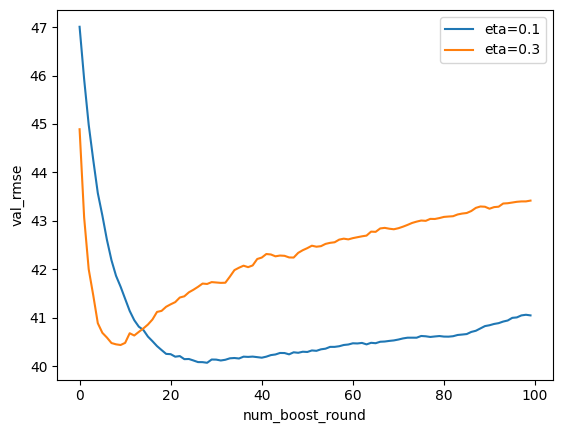

In [23]:
ax = eta_df.query('eta==0.1').plot(x='num_boost_round', y='val_rmse', label='eta=0.1')
eta_df.query('eta==0.3').plot(x='num_boost_round', y='val_rmse', ax=ax, label='eta=0.3')
plt.xlabel('num_boost_round')
plt.ylabel('val_rmse')
plt.legend()
plt.show()